In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from scipy.spatial import distance

SEED = 42

In [2]:
projects = pd.read_csv("../data/nrao_projects.csv")
projects = projects.set_index('project_code')

In [3]:
projects.head()

,project_title,project_abstract,fs_type,science_category,science_keyword,band,target,raw_text,standardized_text,no_sw_text,lemmatized_sw_text,lemmatized_no_sw_text
project_code,,,,,,,,,,,,
2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,line,Galaxy evolution,"Surveys of galaxies, Galaxy groups and clusters",6,1,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,jelly survey of nearby jellyfish and ram press...,jelly survey nearby jellyfish ram pressure str...,jelly survey of nearby jellyfish and ram press...,jelly survey nearby jellyfish ram pressure str...
2022.1.01077.L,A SPectroscopic survey of biased halos In the ...,We propose to obtain deep ALMA 1.2mm mosaic ob...,line,Galaxy evolution,"Sub-mm Galaxies (SMG), High-z Active Galactic ...",6,1,A SPectroscopic survey of biased halos In the ...,a spectroscopic survey of biased halos in the ...,spectroscopic survey biased halos reionization...,a spectroscopic survey of biased halo in the r...,spectroscopic survey bias halos reionization e...
2016.1.00324.L,ASPECS: The ALMA SPECtral line Survey in the U...,ASPECS represents an unparalleled three-dimens...,line,Galaxy evolution,Lyman Break Galaxies (LBG),3,1,ASPECS: The ALMA SPECtral line Survey in the U...,aspecs the spectral line survey in the udf an ...,aspecs spectral line survey udf large program ...,aspecs the spectral line survey in the udf an ...,aspecs spectral line survey udf large program ...
2022.1.00875.L,The ALMA Disk-Exoplanet C/Onnection,Protoplanetary disks set the initial compositi...,line,Disks and planet formation,"Disks around low-mass stars, Exo-planets",7,1,The ALMA Disk-Exoplanet C/Onnection. Protoplan...,the disk exoplanet c onnection protoplanetary ...,disk exoplanet c onnection protoplanetary disk...,the disk exoplanet c onnection protoplanetary ...,disk exoplanet c onnection protoplanetary disk...
2017.1.01355.L,ALMA-IMF: ALMA transforms our view of the orig...,Studying massive protoclusters is an absolute ...,line,ISM and star formation,"High-mass star formation, Low-mass star formation",6,1,ALMA-IMF: ALMA transforms our view of the orig...,imf transforms our view of the origin of stell...,imf transforms view origin stellar masses stud...,imf transform our view of the origin of stella...,imf transforms view origin stellar mass study ...


In [4]:
line_projects = projects.query('fs_type == "line"')
line_projects.shape

(3628, 12)

In [5]:
measurements = pd.read_csv('../../nrao_measurements.csv')
measurements = measurements.set_index('project_code')
measurements = measurements[measurements.fs_type == 'line']

In [6]:
measurements.head()

,project_title,project_abstract,fs_type,low_freq,high_freq,target,diff_freq,med_freq,raw_text,standardized_text,no_sw_text,lemmatized_sw_text,lemmatized_no_sw_text
project_code,,,,,,,,,,,,,
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,90.38,90.62,1,0.24,90.500,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,90.70,90.93,1,0.23,90.815,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,91.69,91.92,1,0.23,91.805,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,92.89,93.12,1,0.23,93.005,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,217.59,218.53,1,0.94,218.060,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...


## Remove outliers from projects and measurements

See 'Identifying_High_Measurement_Projects.ipynb' in 'data' folder

From this notebook, any project with > 26.5 measurements is an outlier

In [7]:
project_measurements = measurements.groupby(measurements.index)\
    .project_title.count()\
        .sort_values(ascending=False)\
        .to_frame()
project_measurements.columns = ['measurement_count']
project_measurements.head()

,measurement_count
project_code,
2017.1.00161.L,289
2017.1.00886.L,283
2021.2.00052.S,265
2023.1.00963.S,253
2022.1.00224.S,188


In [8]:
outliers = project_measurements[project_measurements.measurement_count > 26.5]

In [9]:
measurements = measurements.loc[~measurements.index.isin(outliers.index)]
line_projects = line_projects.loc[~line_projects.index.isin(outliers.index)]

## Train-test split

In [10]:
train_texts, test_texts = train_test_split(line_projects.lemmatized_no_sw_text, random_state=SEED)

In [11]:
print(f'Number of train texts:{len(list(train_texts))}')
print(f'Number of test texts:{len(list(test_texts))}')

Number of train texts:2463
Number of test texts:821


In [12]:
train_texts

project_code
2016.1.00187.S    magnetic field high mass star formation propos...
2013.1.00883.S    hd pristine gas evolve dust transition proto p...
2021.1.00424.S    core brown dwarfs unraveling substellar format...
2013.1.00988.S    understand agn feedback gas chemistry ngc ngc ...
2017.1.00575.S    measure line width rrl blr circinus galaxy pro...
                                        ...                        
2022.1.00453.S    search volatile phosphorus epoch planet format...
2015.1.00453.S    hcn hnc fundamental problem astrophysics two i...
2021.1.01126.S    unveiling nature peculiar embed icy object dis...
2013.1.00328.S    detailed view bird anatomy vital organ rare tr...
2018.A.00063.S    localize feedback process galactic cmz feedbac...
Name: lemmatized_no_sw_text, Length: 2463, dtype: object

### LDA class

In [13]:
class LDA_Model:
    def __init__(self, N_topics=3):
        self.N_topics = N_topics
        self.countVectorizer = CountVectorizer(stop_words='english')
        self.lda = LatentDirichletAllocation(n_components=self.N_topics, random_state=SEED)
    
    def fit(self, corpus):
        termFrequency = self.countVectorizer.fit_transform(corpus)
        self.lda.fit(termFrequency)
        return self.lda.transform(termFrequency)

    # Additional method to transform new data
    def transform(self, corpus):
        termFrequency = self.countVectorizer.transform(corpus)
        return self.lda.transform(termFrequency)

#### Initialize Model

In [14]:
lda_model = LDA_Model(N_topics=50)

#### Fit model on training set

In [15]:
train_topics = lda_model.fit(train_texts)

In [16]:
words = lda_model.countVectorizer.get_feature_names_out()

In [17]:
N = 10 #number of top words to show
topic_components = lda_model.lda.components_

for topic_idx, topic in enumerate(topic_components):
    print(f"Topic {topic_idx}:")
    # Get the indices of the top N words for this topic
    top_word_indices = topic.argsort()[-N:][::-1]
    # Print these words with their weights
    for word_idx in top_word_indices:
        print(f"{words[word_idx]} (weight: {topic[word_idx]:.2f})")
    print("\n")

Topic 0:
grain (weight: 65.51)
disk (weight: 58.59)
dust (weight: 56.38)
observation (weight: 37.19)
growth (weight: 30.22)
propose (weight: 29.70)
streamer (weight: 27.07)
mass (weight: 25.76)
measure (weight: 22.12)
model (weight: 21.69)


Topic 1:
carbon (weight: 82.55)
pdr (weight: 79.47)
line (weight: 71.43)
model (weight: 59.21)
chemical (weight: 49.19)
uv (weight: 48.86)
abundance (weight: 45.20)
molecule (weight: 41.25)
region (weight: 40.93)
observe (weight: 36.16)


Topic 2:
infall (weight: 114.09)
field (weight: 37.60)
region (weight: 32.43)
magnetic (weight: 28.72)
aca (weight: 25.54)
map (weight: 22.72)
environment (weight: 20.48)
study (weight: 20.05)
observation (weight: 16.83)
faraday (weight: 16.31)


Topic 3:
star (weight: 311.81)
formation (weight: 164.01)
disk (weight: 110.04)
high (weight: 91.08)
angular (weight: 87.76)
scale (weight: 83.37)
massive (weight: 82.37)
accretion (weight: 73.43)
form (weight: 72.84)
observation (weight: 68.20)


Topic 4:
emission (weigh

In [18]:
train_doc_topic = pd.DataFrame(train_topics)
train_doc_topic = train_doc_topic.set_index(train_texts.index.values)
train_doc_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2016.1.00187.S,0.000175,0.000175,0.051596,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,...,0.000175,0.000175,0.476002,0.000175,0.000175,0.130695,0.000175,0.000175,0.000175,0.000175
2013.1.00883.S,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,...,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198
2021.1.00424.S,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,...,0.000183,0.000183,0.000183,0.876168,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183
2013.1.00988.S,0.000230,0.000230,0.000230,0.000230,0.000230,0.112832,0.000230,0.000230,0.000230,0.000230,...,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230
2017.1.00575.S,0.000290,0.000290,0.000290,0.000290,0.000290,0.020682,0.000290,0.000290,0.000290,0.000290,...,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290


In [19]:
train_texts = pd.DataFrame(train_texts)

### Match test data into topics

In [20]:
test_topics = lda_model.transform(test_texts)

In [21]:
test_doc_topic= pd.DataFrame(test_topics.tolist())
test_doc_topic= test_doc_topic.set_index(test_texts.index.values)
test_doc_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2017.1.00822.S,0.000204,0.000204,0.000204,0.000204,0.000204,0.625789,0.000204,0.038601,0.000204,0.000204,...,0.000204,0.000204,0.000204,0.000204,0.000204,0.000204,0.000204,0.000204,0.000204,0.000204
2011.0.00629.S,0.000177,0.122896,0.000177,0.000177,0.000177,0.000177,0.000177,0.000177,0.000177,0.000177,...,0.000177,0.000177,0.000177,0.131309,0.000177,0.000177,0.000177,0.000177,0.000177,0.114039
2016.1.01015.S,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,...,0.050184,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225
2016.1.01206.S,0.000247,0.000247,0.000247,0.000247,0.000247,0.000247,0.376084,0.000247,0.000247,0.000247,...,0.064222,0.000247,0.000247,0.000247,0.073479,0.000247,0.000247,0.000247,0.000247,0.000247
2016.1.00650.S,0.000177,0.000177,0.000177,0.000177,0.015123,0.149642,0.000177,0.000177,0.000177,0.263467,...,0.000177,0.000177,0.000177,0.000177,0.000177,0.151149,0.000177,0.000177,0.000177,0.000177


In [22]:
test_texts = pd.DataFrame(test_texts)

## Try comparing two projects based on topic vector similarity using dot product

In [23]:
comp = np.dot(train_doc_topic, test_doc_topic.iloc[1].T)

In [24]:
train_doc_topic.iloc[comp.argmax()].name

'2021.1.01661.S'

In [25]:
comp_frame = pd.DataFrame(comp)\
    .set_index(train_texts.index.values)
comp_frame.columns = ['dot_product_similarity']
comp_frame = comp_frame.sort_values('dot_product_similarity', ascending=False)

In [26]:
comp_frame.shape

(2463, 1)

In [27]:
comp_frame.describe()

,dot_product_similarity
count,2463.000000
mean,0.043760
std,0.074191
min,0.000260
25%,0.000361
50%,0.000477
75%,0.058698
max,0.349356


In [28]:
comp_frame.dot_product_similarity.quantile(q=0.75)

0.05869789456891137

In [29]:
comp_frame.head()

,dot_product_similarity
2021.1.01661.S,0.349356
2022.1.01360.S,0.349330
2015.1.00490.S,0.349330
2017.1.01151.S,0.349277
2018.1.01829.S,0.349222


In [30]:
q4_comp = comp_frame[comp_frame.dot_product_similarity > comp_frame.dot_product_similarity.quantile(q=0.999)]
q4_comp

,dot_product_similarity
2021.1.01661.S,0.349356
2022.1.01360.S,0.349330
2015.1.00490.S,0.349330


In [31]:
px.histogram(q4_comp.dot_product_similarity)

In [32]:
train_texts.iloc[1896]

lemmatized_no_sw_text    star formation inside galactic outflow propert...
Name: 2016.2.00115.S, dtype: object

In [33]:
test_texts.iloc[0]

lemmatized_no_sw_text    survey ism gas rich galaxy z hff cluster mac h...
Name: 2017.1.00822.S, dtype: object

In [34]:
fig = px.scatter(measurements.loc[list(q4_comp.index.values)].med_freq)
#fig.add_trace(px.scatter(measurements.loc['2017.1.01247.S'].med_freq).data[0])
fig

## Loop over test points and find differences between frequency setup for test point and top (ties not resolved...maybe use most recent?) dot product similarity project 

In [35]:
proj_measurements = measurements.query('fs_type == "line"')[['low_freq', 'high_freq', 'diff_freq', 'med_freq']]
proj_measurements = proj_measurements.groupby(proj_measurements.index).agg({
    'low_freq':lambda x: round(x, 4).tolist(),
    'high_freq':lambda x: round(x, 4).tolist(),
    'diff_freq':lambda x: round(x, 4).tolist(),
    'med_freq':lambda x: round(x, 4).tolist()
})
proj_measurements

,low_freq,high_freq,diff_freq,med_freq
project_code,,,,
2011.0.00010.S,"[90.38, 90.7, 91.69, 92.89, 217.59, 218.67, 21...","[90.62, 90.93, 91.92, 93.12, 218.53, 219.6, 21...","[0.24, 0.23, 0.23, 0.23, 0.94, 0.93, 0.94, 0.9...","[90.5, 90.815, 91.805, 93.005, 218.06, 219.135..."
2011.0.00017.S,"[87.72, 89.54, 99.72, 101.54, 91.37, 93.19, 10...","[89.6, 91.42, 101.59, 103.42, 93.24, 95.07, 10...","[1.88, 1.88, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8...","[88.66, 90.48, 100.655, 102.48, 92.305, 94.13,..."
2011.0.00028.S,"[342.36, 344.24, 354.28, 355.79, 342.36]","[344.23, 346.11, 356.16, 357.66, 344.24]","[1.87, 1.87, 1.88, 1.87, 1.88]","[343.295, 345.175, 355.22, 356.725, 343.3]"
2011.0.00039.S,"[338.32, 340.18, 350.37, 352.2]","[340.2, 342.06, 352.24, 354.08]","[1.88, 1.88, 1.87, 1.88]","[339.26, 341.12, 351.305, 353.14]"
2011.0.00046.S,"[99.65, 101.48, 111.52, 113.36]","[101.52, 103.36, 113.4, 115.23]","[1.87, 1.88, 1.88, 1.87]","[100.585, 102.42, 112.46, 114.295]"
...,...,...,...,...
2023.1.01710.S,"[105.15, 103.52, 103.38]","[106.09, 104.45, 104.32]","[0.94, 0.93, 0.94]","[105.62, 103.985, 103.85]"
2023.1.01720.S,"[216.99, 217.88, 220.28, 220.88, 231.56, 234.06]","[217.22, 218.12, 220.52, 221.12, 233.44, 235.94]","[0.23, 0.24, 0.24, 0.24, 1.88, 1.88]","[217.105, 218.0, 220.4, 221.0, 232.5, 235.0]"
2023.1.01721.S,"[340.64, 342.52, 352.66, 354.53]","[342.52, 344.39, 354.54, 356.41]","[1.88, 1.87, 1.88, 1.88]","[341.58, 343.455, 353.6, 355.47]"


In [36]:
proj_measurements.low_freq = proj_measurements.low_freq.apply(lambda x: sorted(x))
proj_measurements.high_freq = proj_measurements.high_freq.apply(lambda x: sorted(x))

In [37]:
proj_measurements.head()

,low_freq,high_freq,diff_freq,med_freq
project_code,,,,
2011.0.00010.S,"[85.96, 87.05, 87.47, 87.65, 88.36, 88.91, 90....","[86.19, 87.29, 87.7, 87.88, 88.59, 89.15, 90.6...","[0.24, 0.23, 0.23, 0.23, 0.94, 0.93, 0.94, 0.9...","[90.5, 90.815, 91.805, 93.005, 218.06, 219.135..."
2011.0.00017.S,"[84.09, 85.9, 87.72, 89.54, 91.37, 93.19, 95.0...","[85.97, 87.78, 89.6, 91.42, 93.24, 95.07, 96.9...","[1.88, 1.88, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8...","[88.66, 90.48, 100.655, 102.48, 92.305, 94.13,..."
2011.0.00028.S,"[342.36, 342.36, 344.24, 354.28, 355.79]","[344.23, 344.24, 346.11, 356.16, 357.66]","[1.87, 1.87, 1.88, 1.87, 1.88]","[343.295, 345.175, 355.22, 356.725, 343.3]"
2011.0.00039.S,"[338.32, 340.18, 350.37, 352.2]","[340.2, 342.06, 352.24, 354.08]","[1.88, 1.88, 1.87, 1.88]","[339.26, 341.12, 351.305, 353.14]"
2011.0.00046.S,"[99.65, 101.48, 111.52, 113.36]","[101.52, 103.36, 113.4, 115.23]","[1.87, 1.88, 1.88, 1.87]","[100.585, 102.42, 112.46, 114.295]"


Create zipped columns

In [38]:
proj_measurements['lh_freq'] = proj_measurements.apply(lambda x: list(zip(x.low_freq, x.high_freq)), axis=1)
proj_measurements['dm_freq'] = proj_measurements.apply(lambda x: list(zip(x.diff_freq, x.med_freq)), axis=1)

In [39]:
proj_measurements.head()

,low_freq,high_freq,diff_freq,med_freq,lh_freq,dm_freq
project_code,,,,,,
2011.0.00010.S,"[85.96, 87.05, 87.47, 87.65, 88.36, 88.91, 90....","[86.19, 87.29, 87.7, 87.88, 88.59, 89.15, 90.6...","[0.24, 0.23, 0.23, 0.23, 0.94, 0.93, 0.94, 0.9...","[90.5, 90.815, 91.805, 93.005, 218.06, 219.135...","[(85.96, 86.19), (87.05, 87.29), (87.47, 87.7)...","[(0.24, 90.5), (0.23, 90.815), (0.23, 91.805),..."
2011.0.00017.S,"[84.09, 85.9, 87.72, 89.54, 91.37, 93.19, 95.0...","[85.97, 87.78, 89.6, 91.42, 93.24, 95.07, 96.9...","[1.88, 1.88, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8...","[88.66, 90.48, 100.655, 102.48, 92.305, 94.13,...","[(84.09, 85.97), (85.9, 87.78), (87.72, 89.6),...","[(1.88, 88.66), (1.88, 90.48), (1.87, 100.655)..."
2011.0.00028.S,"[342.36, 342.36, 344.24, 354.28, 355.79]","[344.23, 344.24, 346.11, 356.16, 357.66]","[1.87, 1.87, 1.88, 1.87, 1.88]","[343.295, 345.175, 355.22, 356.725, 343.3]","[(342.36, 344.23), (342.36, 344.24), (344.24, ...","[(1.87, 343.295), (1.87, 345.175), (1.88, 355...."
2011.0.00039.S,"[338.32, 340.18, 350.37, 352.2]","[340.2, 342.06, 352.24, 354.08]","[1.88, 1.88, 1.87, 1.88]","[339.26, 341.12, 351.305, 353.14]","[(338.32, 340.2), (340.18, 342.06), (350.37, 3...","[(1.88, 339.26), (1.88, 341.12), (1.87, 351.30..."
2011.0.00046.S,"[99.65, 101.48, 111.52, 113.36]","[101.52, 103.36, 113.4, 115.23]","[1.87, 1.88, 1.88, 1.87]","[100.585, 102.42, 112.46, 114.295]","[(99.65, 101.52), (101.48, 103.36), (111.52, 1...","[(1.87, 100.585), (1.88, 102.42), (1.88, 112.4..."


In [40]:
best_matches = {}
for proj in test_doc_topic.index.values:
    dot_product = np.dot(train_doc_topic, test_doc_topic.loc[proj].T)
    best_matches[proj] = train_doc_topic.iloc[dot_product.argmax()].name

In [41]:
best_matches_frame = pd.DataFrame.from_dict(best_matches, orient='index')
best_matches_frame.columns = ['best_match']
best_matches_frame = best_matches_frame.reset_index()
best_matches_frame = best_matches_frame.set_index('index')
best_matches_frame.index = best_matches_frame.index.rename('test_project')
best_matches_frame.head()

,best_match
test_project,
2017.1.00822.S,2021.1.01603.S
2011.0.00629.S,2021.1.01661.S
2016.1.01015.S,2018.1.01826.S
2016.1.01206.S,2012.1.01123.S
2016.1.00650.S,2017.1.01013.S


In [42]:
best_matches_frame.describe()

,best_match
count,821
unique,57
top,2021.1.01603.S
freq,158


In [43]:
best_matches_frame.value_counts().describe()

count     57.000000
mean      14.403509
std       27.679840
min        1.000000
25%        1.000000
50%        5.000000
75%       13.000000
max      158.000000
Name: count, dtype: float64

In [44]:
train_doc_topic.loc['2017.1.00815.S']

0     0.000192
1     0.000192
2     0.000192
3     0.000192
4     0.000192
5     0.000192
6     0.000192
7     0.000192
8     0.000192
9     0.000192
10    0.000192
11    0.000192
12    0.000192
13    0.730182
14    0.000192
15    0.000192
16    0.000192
17    0.000192
18    0.000192
19    0.000192
20    0.000192
21    0.000192
22    0.000192
23    0.000192
24    0.000192
25    0.000192
26    0.000192
27    0.000192
28    0.260587
29    0.000192
30    0.000192
31    0.000192
32    0.000192
33    0.000192
34    0.000192
35    0.000192
36    0.000192
37    0.000192
38    0.000192
39    0.000192
40    0.000192
41    0.000192
42    0.000192
43    0.000192
44    0.000192
45    0.000192
46    0.000192
47    0.000192
48    0.000192
49    0.000192
Name: 2017.1.00815.S, dtype: float64

In [45]:
best_matches_frame[best_matches_frame.best_match == '2017.1.00815.S']

,best_match
test_project,


## Compare best match frequency setups

In [46]:
def find_common_elements(list1, list2) -> list:
    set1 = set(list1)
    set2 = set(list2)
    
    return list(set1.intersection(set2))

In [47]:
def compare_matches(matches_frame:pd.DataFrame, comp_column:str, round:int) -> list:
    percent_test_match_list = []
    for test_proj in matches_frame.index:
        match_proj = matches_frame.loc[test_proj].best_match
        test_measurements = np.round(proj_measurements.loc[test_proj][comp_column], round)
        match_measurements = np.round(proj_measurements.loc[match_proj][comp_column], round)
        common_elements = find_common_elements(test_measurements, match_measurements)
        percent_test_match = len(common_elements)/len(test_measurements)
        percent_test_match_list.append(percent_test_match)
        print(f'Test project {test_proj} compared to best match {match_proj}')
        print(f'len(matched measurements)/len(test measurements) = {percent_test_match}')
    return percent_test_match_list

In [48]:
np.mean(compare_matches(best_matches_frame, 'med_freq', 0))

Test project 2017.1.00822.S compared to best match 2021.1.01603.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2011.0.00629.S compared to best match 2021.1.01661.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2016.1.01015.S compared to best match 2018.1.01826.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2016.1.01206.S compared to best match 2012.1.01123.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2016.1.00650.S compared to best match 2017.1.01013.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2019.1.01072.S compared to best match 2015.1.01460.S
len(matched measurements)/len(test measurements) = 0.5
Test project 2012.1.00707.S compared to best match 2019.1.00312.S
len(matched measurements)/len(test measurements) = 0.4
Test project 2021.A.00034.S compared to best match 2019.1.01279.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2022.1.00986.S comp

0.08072972533599518

## Try comparing documents to documents in top matched topic

### Group documents to highest matching topic

Combine project topic vector frames

In [49]:
proj_topics = pd.concat([train_doc_topic, test_doc_topic])
proj_topics

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2016.1.00187.S,0.000175,0.000175,0.051596,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,...,0.000175,0.000175,0.476002,0.000175,0.000175,0.130695,0.000175,0.000175,0.000175,0.000175
2013.1.00883.S,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,...,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198
2021.1.00424.S,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,...,0.000183,0.000183,0.000183,0.876168,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183
2013.1.00988.S,0.000230,0.000230,0.000230,0.000230,0.000230,0.112832,0.000230,0.000230,0.000230,0.000230,...,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230
2017.1.00575.S,0.000290,0.000290,0.000290,0.000290,0.000290,0.020682,0.000290,0.000290,0.000290,0.000290,...,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017.1.01108.S,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,...,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208
2022.1.00873.V,0.000190,0.000190,0.000190,0.000190,0.095013,0.000190,0.000190,0.480779,0.000190,0.000190,...,0.000190,0.000190,0.000190,0.084450,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190
2023.1.00717.S,0.000180,0.120219,0.000180,0.093377,0.000180,0.000180,0.000180,0.000180,0.000180,0.068492,...,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180
2023.1.01276.S,0.000198,0.000198,0.000198,0.159681,0.000198,0.121163,0.000198,0.000198,0.000198,0.000198,...,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198


Take highest matching topic for each project

In [50]:
proj_topics['max_topic'] = proj_topics.apply(lambda x: x.argmax(), axis=1)

Create data frame with project id and max topic

In [51]:
proj_max_topic = proj_topics['max_topic'].to_frame()
proj_max_topic

,max_topic
2016.1.00187.S,42
2013.1.00883.S,20
2021.1.00424.S,43
2013.1.00988.S,30
2017.1.00575.S,31
...,...
2017.1.01108.S,34
2022.1.00873.V,7
2023.1.00717.S,31
2023.1.01276.S,20


Inspect distribution of max topic

In [52]:
proj_max_topic.value_counts().describe()

count     50.000000
mean      65.680000
std       94.162352
min        5.000000
25%       17.500000
50%       35.500000
75%       84.000000
max      527.000000
Name: count, dtype: float64

There are a few topics that match to a large number of documents

Append project max topic to measurements for ease of grouping documents

In [53]:
proj_measurements = proj_measurements.join(proj_max_topic, how='left')
proj_measurements

,low_freq,high_freq,diff_freq,med_freq,lh_freq,dm_freq,max_topic
project_code,,,,,,,
2011.0.00010.S,"[85.96, 87.05, 87.47, 87.65, 88.36, 88.91, 90....","[86.19, 87.29, 87.7, 87.88, 88.59, 89.15, 90.6...","[0.24, 0.23, 0.23, 0.23, 0.94, 0.93, 0.94, 0.9...","[90.5, 90.815, 91.805, 93.005, 218.06, 219.135...","[(85.96, 86.19), (87.05, 87.29), (87.47, 87.7)...","[(0.24, 90.5), (0.23, 90.815), (0.23, 91.805),...",40
2011.0.00017.S,"[84.09, 85.9, 87.72, 89.54, 91.37, 93.19, 95.0...","[85.97, 87.78, 89.6, 91.42, 93.24, 95.07, 96.9...","[1.88, 1.88, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8...","[88.66, 90.48, 100.655, 102.48, 92.305, 94.13,...","[(84.09, 85.97), (85.9, 87.78), (87.72, 89.6),...","[(1.88, 88.66), (1.88, 90.48), (1.87, 100.655)...",16
2011.0.00028.S,"[342.36, 342.36, 344.24, 354.28, 355.79]","[344.23, 344.24, 346.11, 356.16, 357.66]","[1.87, 1.87, 1.88, 1.87, 1.88]","[343.295, 345.175, 355.22, 356.725, 343.3]","[(342.36, 344.23), (342.36, 344.24), (344.24, ...","[(1.87, 343.295), (1.87, 345.175), (1.88, 355....",20
2011.0.00039.S,"[338.32, 340.18, 350.37, 352.2]","[340.2, 342.06, 352.24, 354.08]","[1.88, 1.88, 1.87, 1.88]","[339.26, 341.12, 351.305, 353.14]","[(338.32, 340.2), (340.18, 342.06), (350.37, 3...","[(1.88, 339.26), (1.88, 341.12), (1.87, 351.30...",25
2011.0.00046.S,"[99.65, 101.48, 111.52, 113.36]","[101.52, 103.36, 113.4, 115.23]","[1.87, 1.88, 1.88, 1.87]","[100.585, 102.42, 112.46, 114.295]","[(99.65, 101.52), (101.48, 103.36), (111.52, 1...","[(1.87, 100.585), (1.88, 102.42), (1.88, 112.4...",3
...,...,...,...,...,...,...,...
2023.1.01710.S,"[103.38, 103.52, 105.15]","[104.32, 104.45, 106.09]","[0.94, 0.93, 0.94]","[105.62, 103.985, 103.85]","[(103.38, 104.32), (103.52, 104.45), (105.15, ...","[(0.94, 105.62), (0.93, 103.985), (0.94, 103.85)]",23
2023.1.01720.S,"[216.99, 217.88, 220.28, 220.88, 231.56, 234.06]","[217.22, 218.12, 220.52, 221.12, 233.44, 235.94]","[0.23, 0.24, 0.24, 0.24, 1.88, 1.88]","[217.105, 218.0, 220.4, 221.0, 232.5, 235.0]","[(216.99, 217.22), (217.88, 218.12), (220.28, ...","[(0.23, 217.105), (0.24, 218.0), (0.24, 220.4)...",29
2023.1.01721.S,"[340.64, 342.52, 352.66, 354.53]","[342.52, 344.39, 354.54, 356.41]","[1.88, 1.87, 1.88, 1.88]","[341.58, 343.455, 353.6, 355.47]","[(340.64, 342.52), (342.52, 344.39), (352.66, ...","[(1.88, 341.58), (1.87, 343.455), (1.88, 353.6...",48


Check it worked

In [54]:
proj_max_topic.loc[['2011.0.00010.S', '2011.0.00017.S', '2023.A.00009.S']]

,max_topic
2011.0.00010.S,40
2011.0.00017.S,16
2023.A.00009.S,20


Eyeball comparison of documents by max topic

In [55]:
proj_max_topic[proj_max_topic.max_topic == 3]

,max_topic
2022.1.00383.S,3
2016.1.01367.S,3
2015.1.00320.S,3
2015.1.01596.S,3
2018.1.01740.S,3
...,...
2016.1.01609.S,3
2015.1.00496.S,3
2016.A.00008.T,3
2016.1.01147.S,3


Plot frequency setups for these projects

This is a spicy cell depending on the number of topics so take care!

In [56]:
# for topic in np.sort(proj_max_topic.max_topic.unique()):
#     plt.figure()
#     plt.title(f'Frequency Median vs Frequency Difference for Topic {topic}')
#     plt.scatter(x=measurements.loc[list(proj_max_topic[proj_max_topic.max_topic == topic].index)].med_freq,
#                 y=measurements.loc[list(proj_max_topic[proj_max_topic.max_topic == topic].index)].diff_freq)

What if for each topic, we simply cluster frequency measurements using DBSCAN?

Create topic-project data frame

Add frequency measurements to `proj_max_topic`

In [57]:
proj_max_topic = proj_max_topic.join(proj_measurements[['lh_freq', 'dm_freq']])
proj_max_topic

,max_topic,lh_freq,dm_freq
2016.1.00187.S,42,"[(113.09, 113.56), (115.16, 115.39)]","[(0.47, 113.325), (0.23, 115.275)]"
2013.1.00883.S,20,"[(109.75, 109.81), (110.17, 110.23)]","[(0.06, 109.78), (0.06, 110.2)]"
2021.1.00424.S,43,"[(216.07, 217.94), (218.32, 220.19), (230.3, 2...","[(1.87, 217.005), (1.87, 219.255), (0.47, 230...."
2013.1.00988.S,30,"[(85.0, 86.87), (86.87, 88.75), (88.75, 90.62)...","[(1.87, 89.685), (1.88, 91.56), (1.87, 101.685..."
2017.1.00575.S,31,"[(84.53, 86.4), (85.53, 87.4), (97.14, 99.02),...","[(1.87, 135.785), (1.87, 137.285), (1.87, 147...."
...,...,...,...
2017.1.01108.S,34,"[(87.34, 89.21), (89.34, 91.21), (95.94, 96.41...","[(0.47, 96.175), (0.47, 96.495), (0.47, 97.055..."
2022.1.00873.V,7,"[(212.14, 214.01), (214.14, 216.01), (226.14, ...","[(1.87, 213.075), (1.87, 215.075), (1.87, 227...."
2023.1.00717.S,31,"[(884.47, 886.47), (886.35, 888.35), (888.22, ...","[(2.0, 885.47), (2.0, 887.35), (2.0, 889.22), ..."
2023.1.01276.S,20,"[(343.05, 344.93), (343.07, 344.95), (345.27, ...","[(1.88, 343.99), (0.12, 345.33), (0.11, 345.78..."


In [58]:
train_topic_projects = proj_max_topic.loc[list(train_texts.index.values)]
train_topic_projects = train_topic_projects.reset_index()
train_topic_projects = train_topic_projects.groupby(['max_topic', 'index'])\
    .agg({
        'lh_freq': lambda x: x,
        'dm_freq': lambda x: x
    })
train_topic_projects.index.names = ['max_topic', 'project_code']
train_topic_projects

lh_freq  \
max_topic project_code                                                        
0         2011.0.00259.S  [(85.16, 87.03), (85.17, 87.04), (85.17, 87.05...   
          2012.1.00712.S  [(89.49, 89.72), (92.78, 93.02), (102.49, 102....   
          2013.1.00498.S  [(219.49, 219.95), (219.49, 219.96), (219.96, ...   
          2013.1.00546.S  [(216.38, 218.33), (216.4, 218.33), (216.45, 2...   
          2016.1.01042.S  [(108.46, 110.33), (108.46, 110.34), (219.49, ...   
...                                                                     ...   
49        2017.1.00670.S  [(332.01, 332.13), (332.03, 332.15), (332.45, ...   
          2017.1.01514.V  [(85.33, 87.2), (85.34, 87.2), (87.33, 89.2), ...   
          2018.1.00072.S  [(225.64, 225.76), (226.25, 226.37), (226.6, 2...   
          2019.1.00216.S  [(346.44, 346.56), (346.48, 346.6), (346.6, 34...   
          2021.1.01297.S  [(393.59, 395.45), (395.42, 397.29), (405.46, ...   

                                                                    dm_freq  
max_topic project_code                                                       
0         2011.0.00259.S  [(1.88, 86.11), (1.88, 88.0), (1.88, 98.11), (...  
          2012.1.00712.S  [(0.47, 222.005), (0.47, 224.995), (0.47, 239....  
          2013.1.00498.S  [(0.46, 219.72), (0.46, 220.19), (0.47, 230.72...  
          2013.1.00546.S  [(1.99, 217.395), (1.99, 219.195), (2.0, 231.2...  
          2016.1.01042.S  [(0.47, 219.735), (0.46, 220.2), (0.46, 230.71...  
...                                                                     ...  
49        2017.1.00670.S  [(0.12, 332.09), (0.06, 332.5), (0.06, 333.04)...  
          2017.1.01514.V  [(1.86, 86.27), (1.86, 88.27), (1.86, 98.33), ...  
          2018.1.00072.S  [(0.12, 225.7), (0.12, 226.31), (0.12, 226.66)...  
          2019.1.00216.S  [(0.12, 346.5), (0.06, 346.63), (0.06, 347.71)...  
          2021.1.01297.S  [(1.86, 394.52), (1.87, 396.355), (1.87, 406.3...  

[2463 rows x 2 columns]

Combine frequency columns into `max_topic`

In [59]:
train_measurements = measurements.loc[list(train_texts.index.values)]
train_measurements = train_measurements.join(proj_max_topic.loc[list(train_texts.index.values)])
train_measurements.head()

,project_title,project_abstract,fs_type,low_freq,high_freq,target,diff_freq,med_freq,raw_text,standardized_text,no_sw_text,lemmatized_sw_text,lemmatized_no_sw_text,max_topic,lh_freq,dm_freq
project_code,,,,,,,,,,,,,,,,
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,90.38,90.62,1,0.24,90.500,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...,40,"[(85.96, 86.19), (87.05, 87.29), (87.47, 87.7)...","[(0.24, 90.5), (0.23, 90.815), (0.23, 91.805),..."
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,90.70,90.93,1,0.23,90.815,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...,40,"[(85.96, 86.19), (87.05, 87.29), (87.47, 87.7)...","[(0.24, 90.5), (0.23, 90.815), (0.23, 91.805),..."
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,91.69,91.92,1,0.23,91.805,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...,40,"[(85.96, 86.19), (87.05, 87.29), (87.47, 87.7)...","[(0.24, 90.5), (0.23, 90.815), (0.23, 91.805),..."
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,92.89,93.12,1,0.23,93.005,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...,40,"[(85.96, 86.19), (87.05, 87.29), (87.47, 87.7)...","[(0.24, 90.5), (0.23, 90.815), (0.23, 91.805),..."
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,217.59,218.53,1,0.94,218.060,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...,40,"[(85.96, 86.19), (87.05, 87.29), (87.47, 87.7)...","[(0.24, 90.5), (0.23, 90.815), (0.23, 91.805),..."


In [60]:
max_topic_train_freqs = train_measurements.groupby('max_topic')\
    .agg({
        'low_freq': lambda x: round(x, 4).tolist(),
        'high_freq': lambda x: round(x, 4).tolist(),
        'med_freq': lambda x: round(x, 4).tolist(),
        'diff_freq': lambda x: round(x, 4).tolist()
    })
max_topic_train_freqs

,low_freq,high_freq,med_freq,diff_freq
max_topic,,,,
0,"[85.17, 87.06, 97.17, 99.06, 330.14, 332.04, 3...","[87.05, 88.94, 99.05, 100.94, 332.02, 333.91, ...","[86.11, 88.0, 98.11, 100.0, 331.08, 332.975, 3...","[1.88, 1.88, 1.88, 1.88, 1.88, 1.87, 1.88, 1.8..."
1,"[95.29, 97.16, 107.41, 109.28, 84.08, 85.94, 9...","[97.17, 99.04, 109.29, 111.16, 85.95, 87.82, 9...","[96.23, 98.1, 108.35, 110.22, 85.015, 86.88, 9...","[1.88, 1.88, 1.88, 1.88, 1.87, 1.88, 1.88, 1.8..."
2,"[215.71, 217.59, 229.64, 231.59, 100.18, 101.9...","[217.59, 219.46, 231.51, 233.47, 102.05, 103.8...","[216.65, 218.525, 230.575, 232.53, 101.115, 10...","[1.88, 1.87, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8..."
3,"[99.65, 101.48, 111.52, 113.36, 330.37, 332.05...","[101.52, 103.36, 113.4, 115.23, 331.36, 333.03...","[100.585, 102.42, 112.46, 114.295, 330.865, 33...","[1.87, 1.88, 1.88, 1.87, 0.99, 0.98, 0.98, 0.9..."
4,"[214.03, 216.14, 229.57, 231.63, 216.94, 219.1...","[215.9, 218.01, 231.44, 233.51, 218.81, 221.01...","[214.965, 217.075, 230.505, 232.57, 217.875, 2...","[1.87, 1.87, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8..."
5,"[288.96, 290.79, 300.84, 302.71, 288.94, 290.7...","[290.84, 292.67, 302.71, 304.59, 290.82, 292.6...","[289.9, 291.73, 301.775, 303.65, 289.88, 291.7...","[1.88, 1.88, 1.87, 1.88, 1.88, 1.87, 1.88, 1.8..."
6,"[238.84, 239.6, 253.11, 256.11, 612.16, 613.69...","[239.31, 241.48, 254.98, 256.58, 612.75, 614.7...","[239.075, 240.54, 254.045, 256.345, 612.455, 6...","[0.47, 1.88, 1.87, 0.47, 0.59, 1.06, 1.06, 1.0..."
7,"[345.56, 347.09, 356.5, 357.06, 691.0, 693.82,...","[346.03, 347.56, 356.97, 358.94, 691.94, 694.7...","[345.795, 347.325, 356.735, 358.0, 691.47, 694...","[0.47, 0.47, 0.47, 1.88, 0.94, 0.94, 0.94, 0.9..."
8,"[229.61, 645.03, 657.48, 664.02, 712.82, 690.9...","[231.48, 646.02, 658.47, 665.01, 713.8, 691.93...","[230.545, 645.525, 657.975, 664.515, 713.31, 6...","[1.87, 0.99, 0.99, 0.99, 0.98, 0.98, 0.98, 0.9..."


In [251]:
inspect_topic = 6

In [252]:
#db = DBSCAN(eps=3, min_samples=19).fit(list(zip(max_topic_train_freqs.loc[47].med_freq, max_topic_train_freqs.loc[47].diff_freq)))
#db = DBSCAN(eps=0.3, min_samples=5).fit(list(zip(max_topic_train_freqs.loc[inspect_topic].med_freq))) # 13 is interesting
#db = DBSCAN(eps=2, min_samples=2).fit(list(zip(max_topic_train_freqs.loc[inspect_topic].med_freq))) #for topic 30
#db = DBSCAN(eps=5, min_samples=2).fit(list(zip(max_topic_train_freqs.loc[inspect_topic].med_freq))) #for topic 30 all previous with outliers included
# db = DBSCAN(eps=1, min_samples=2).fit(list(zip(max_topic_train_freqs.loc[inspect_topic].med_freq))) # for topic 3 with outliers removed
db = DBSCAN(eps=0.5, min_samples=2).fit(list(zip(max_topic_train_freqs.loc[inspect_topic].med_freq)))

In [253]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_points = len(list(labels))
n_noise = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Total number of measurements: %d" % n_points)
print("Estimated number of noise measurements: %d" % n_noise)
print(f'Signal to noise ratio: {round(list(labels).count(-1)/labels.shape[0], 3)}')

Estimated number of clusters: 7
Total number of measurements: 32
Estimated number of noise measurements: 17
Signal to noise ratio: 0.531


In [254]:
np.array(list(zip(max_topic_train_freqs.loc[inspect_topic].med_freq)))

array([[239.075],
       [240.54 ],
       [254.045],
       [256.345],
       [612.455],
       [614.22 ],
       [625.01 ],
       [625.95 ],
       [256.225],
       [257.405],
       [258.125],
       [258.975],
       [271.945],
       [272.855],
       [344.82 ],
       [345.61 ],
       [345.8  ],
       [354.51 ],
       [355.48 ],
       [354.7  ],
       [218.43 ],
       [219.55 ],
       [232.41 ],
       [232.94 ],
       [218.44 ],
       [219.56 ],
       [232.415],
       [353.57 ],
       [354.44 ],
       [362.64 ],
       [363.61 ],
       [363.78 ]])

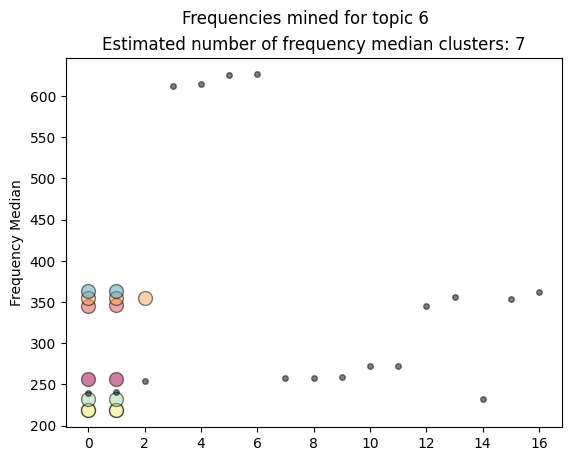

In [255]:
import matplotlib.pyplot as plt
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

#X = np.array(list(zip(max_topic_train_freqs.loc[47].med_freq, max_topic_train_freqs.loc[47].diff_freq)))
X = np.array(list(zip(max_topic_train_freqs.loc[inspect_topic].med_freq)))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=10,
        alpha=0.5
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=4,
        alpha=0.5
    )

plt.title(f"Estimated number of frequency median clusters: {n_clusters}")
plt.ylabel('Frequency Median')
plt.suptitle(f"Frequencies mined for topic {inspect_topic}")
plt.show()

Inspect measurements for this max topic to see if their number of measurements is similar to the number of clusters

In [256]:
train_measurements.query(f'max_topic == {inspect_topic}')\
    .groupby(train_measurements.query(f'max_topic == {inspect_topic}').index.values)\
    .count().describe()

,project_title,project_abstract,fs_type,low_freq,high_freq,target,diff_freq,med_freq,raw_text,standardized_text,no_sw_text,lemmatized_sw_text,lemmatized_no_sw_text,max_topic,lh_freq,dm_freq
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000,6.400000
std,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547,3.361547
min,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
25%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
max,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000


Assign labels to measurements for topic and find cluster centers

In [257]:
selected_topic = pd.DataFrame(max_topic_train_freqs.loc[inspect_topic].med_freq, max_topic_train_freqs.loc[inspect_topic].diff_freq)\
    .reset_index()
selected_topic.columns = ['diff_freq', 'med_freq']
selected_topic['cluster_freq'] = pd.Series(labels)
selected_topic

,diff_freq,med_freq,cluster_freq
0,0.47,239.075,-1
1,1.88,240.540,-1
2,1.87,254.045,-1
3,0.47,256.345,0
4,0.59,612.455,-1
5,1.06,614.220,-1
6,1.06,625.010,-1
7,1.06,625.950,-1
8,0.23,256.225,0
9,0.23,257.405,-1


In [258]:
topic_cluster = selected_topic.groupby('cluster_freq').mean()

In [259]:
topic_cluster['lower_bound'] = topic_cluster.med_freq - (topic_cluster.diff_freq/2)
topic_cluster['upper_bound'] = topic_cluster.med_freq + (topic_cluster.diff_freq/2)
# topic_cluster['lower_bound'] = topic_cluster.med_freq - (2)
# topic_cluster['upper_bound'] = topic_cluster.med_freq + (2)
topic_cluster.sort_values('lower_bound', ascending=True)

,diff_freq,med_freq,lower_bound,upper_bound
cluster_freq,,,,
3,0.060000,218.435000,218.405000,218.465000
4,0.060000,219.555000,219.525000,219.585000
5,0.055000,232.412500,232.385000,232.440000
0,0.350000,256.285000,256.110000,256.460000
1,0.120000,345.705000,345.645000,345.765000
2,0.100000,354.550000,354.500000,354.600000
-1,0.972941,363.532353,363.045882,364.018824
6,0.970000,363.695000,363.210000,364.180000


In [260]:
test_max_topic = test_doc_topic.idxmax(axis=1).to_frame()
test_max_topic.columns = ['max_topic']
test_max_topic.query(f'max_topic == {inspect_topic}')

,max_topic
2016.1.01206.S,6
2021.1.00736.S,6
2011.0.00136.S,6
2018.1.00879.S,6
2011.0.00727.S,6
2017.1.00636.S,6
2011.0.00808.S,6
2021.1.00162.S,6
2013.1.00446.S,6


In [261]:
sorted(proj_measurements.loc[test_max_topic.query(f'max_topic == {inspect_topic}').index.values].med_freq.values)

[[215.695, 216.695, 229.52, 230.52],
 [245.22,
  245.29,
  245.35,
  245.92,
  247.46,
  248.465,
  258.215,
  258.985,
  259.83,
  260.945,
  261.835,
  248.465,
  258.215,
  258.985,
  260.945,
  261.84],
 [331.27, 330.57, 344.29, 345.17, 345.78, 325.14, 325.135, 335.38, 335.38],
 [335.405, 336.1, 345.79, 346.585],
 [342.885, 345.8, 355.205, 354.51],
 [344.45, 345.685, 354.585],
 [344.98, 345.78, 354.49, 355.285, 344.975, 354.49, 355.285],
 [349.275, 349.47, 362.07, 362.655, 354.53, 354.72, 354.925, 356.025],
 [349.44,
  349.55,
  349.795,
  362.0,
  362.63,
  363.785,
  349.43,
  349.54,
  349.78,
  361.99,
  362.62,
  363.77,
  349.79,
  361.995,
  363.78,
  349.425,
  349.53,
  361.985,
  362.615]]

In [263]:
# Add closest match frequency cluster!!!!!!!
test_project_index = 0
matches = 0
for freq in list(proj_measurements.loc[test_max_topic.query(f'max_topic == {inspect_topic}').index.values].med_freq.values[test_project_index]):
    print(f'Testing frequency measurement {freq}')
    for cluster in topic_cluster.index.values:
        lower_bound = round(topic_cluster.iloc[cluster].lower_bound, 3)
        upper_bound = round(topic_cluster.iloc[cluster].upper_bound, 3)
        if ((freq >= lower_bound) and (freq <= upper_bound)):
            print(f'Test frequency measurement {freq} matches to cluster {cluster} range {lower_bound}-{upper_bound}')
            matches += 1
    num_measurements = len(list(proj_measurements.loc[test_max_topic.query(f'max_topic == {inspect_topic}').index.values].med_freq.values[test_project_index]))
    print(f'Percent matches: {matches/num_measurements}')
    print('====================')

Testing frequency measurement 331.27
Percent matches: 0.0
Testing frequency measurement 330.57
Percent matches: 0.0
Testing frequency measurement 344.29
Percent matches: 0.0
Testing frequency measurement 345.17
Percent matches: 0.0
Testing frequency measurement 345.78
Percent matches: 0.0
Testing frequency measurement 325.14
Percent matches: 0.0
Testing frequency measurement 325.135
Percent matches: 0.0
Testing frequency measurement 335.38
Percent matches: 0.0
Testing frequency measurement 335.38
Percent matches: 0.0
